In [1]:
!pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.fftpack import fft

In [4]:
data0D = pd.read_csv("0D.csv")
data0E = pd.read_csv('0E.csv')
data1D = pd.read_csv('1D.csv')
data1E = pd.read_csv('1E.csv')
data2D = pd.read_csv('2D.csv')
data2E = pd.read_csv('2E.csv')
data3D = pd.read_csv('3D.csv')
data3E = pd.read_csv('3E.csv')
data4D = pd.read_csv('4D.csv')
data4E = pd.read_csv('4E.csv')

In [5]:
skip = 50000
data0D = data0D.iloc[skip:,:]
data1D = data1D.iloc[skip:,:]
data2D = data2D.iloc[skip:,:]
data3D = data3D.iloc[skip:,:]
data4D = data4D.iloc[skip:,:]
data0E = data0E.iloc[skip:,:]
data1E = data1E.iloc[skip:,:]
data2E = data2E.iloc[skip:,:]
data3E = data3E.iloc[skip:,:]
data4E = data4E.iloc[skip:,:]

In [6]:
!pip install datasets


Defaulting to user installation because normal site-packages is not writeable


In [7]:
# add python path to include src directory
import sys
sys.path.insert(0, '../src')

# standard library imports
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple
import math

# related third party imports
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from transformers import BertTokenizer
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from tqdm import tqdm

# local library specific imports
from transformers import BertForSequenceClassification as MyBertForSequenceClassification

In [8]:
labels = {'no_unbalance':0, 'unbalance':1}
sensor = 'Vibration_1'
samples_per_second = 4096
seconds_per_analysis = 1.0
window = int(samples_per_second*seconds_per_analysis)

def get_features(data, label):
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))
    y = np.ones(n)*labels[label]
    return X,y

X0,y0 = get_features(data0D[sensor], "no_unbalance")
X1,y1 = get_features(data1D[sensor], "unbalance")
X2,y2 = get_features(data2D[sensor], "unbalance")
X3,y3 = get_features(data3D[sensor], "unbalance")
X4,y4 = get_features(data4D[sensor], "unbalance")
X=np.concatenate([X0,X1,X2,X3,X4])
y=np.concatenate([y0,y1,y2,y3,y4])

X0_val, y0_val = get_features(data0E[sensor], "no_unbalance")
X1_val, y1_val = get_features(data1E[sensor], "unbalance")
X2_val, y2_val = get_features(data2E[sensor], "unbalance")
X3_val, y3_val = get_features(data3E[sensor], "unbalance")
X4_val, y4_val = get_features(data4E[sensor], "unbalance")
X_val=np.concatenate([X0_val,X1_val,X2_val,X3_val,X4_val])
y_val=np.concatenate([y0_val,y1_val,y2_val,y3_val,y4_val])

In [9]:
len(X_val)

8359

In [10]:
vibration_data = X_val.tolist()
labels = y_val.tolist()

# Apply FFT along the time axis (axis=1)
vibration_data_fft = np.abs(np.fft.fft(vibration_data, axis=1))
#vibration_data_abs=np.abs(vibration_data)

# Convert numerical data to text
vibration_data_text = [",".join(map(str, signal)) for signal in vibration_data_fft]

data_dict = {
    'text': vibration_data_text,
    'label': labels
}


In [11]:
len(vibration_data_text)

8359

In [12]:
X_val.shape

(8359, 4096)

In [13]:
y_val.shape

(8359,)

In [14]:
# load data into hugging face dataset object
dataset_stackoverflow = Dataset.from_dict(data_dict)

In [15]:

# define the indices at which to split the dataset into train/validation/test
n_samples = len(dataset_stackoverflow)
split_idx1 = int(n_samples * 0.8)
split_idx2 = int(n_samples * 0.9)

# shuffle the dataset
shuffled_dataset = dataset_stackoverflow.shuffle(seed=5)

# split dataset training/validation/test
train_dataset = shuffled_dataset.select(range(split_idx1))
val_dataset = shuffled_dataset.select(range(split_idx1, split_idx2))
test_dataset = shuffled_dataset.select(range(split_idx2, n_samples))

In [16]:
len(test_dataset)

836

In [17]:
n_samples

8359

In [18]:
# load the datasets into a dataloader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [19]:
import os

In [20]:
class BertTrainer:
    """ A training and evaluation loop for PyTorch models with a BERT like architecture. """

    def __init__(
        self, 
        model,
        tokenizer,
        train_dataloader,
        eval_dataloader=None,
        epochs=1,
        lr=5e-04,
        output_dir='./',
        output_filename='model_state_dict.pt',
        save=False,
        tabular=False,
    ):
        """
        Args:
            model: torch.nn.Module: A PyTorch model with a BERT like architecture,
            tokenizer: A BERT tokenizer for tokenizing text input,
            train_dataloader: torch.utils.data.DataLoader: A dataloader containing the training data with "text" and "label" keys,
            eval_dataloader: torch.utils.data.DataLoader: A dataloader containing the evaluation data with "text" and "label" keys,
            epochs: int: An integer representing the number epochs to train,
            lr: float: A float representing the learning rate for the optimizer,
            output_dir: str: A string representing the directory path to save the model,
            output_filename: str: A string representing the name of the file to save in the output directory,
            save: bool: A boolean representing whether or not to save the model,
            tabular: bool: A boolean representing whether or not the BERT model is modified to accept tabular data,
        """
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.tokenizer = tokenizer
        self.train_dataloader = train_dataloader
        self.eval_dataloader = eval_dataloader
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        self.loss_fn = nn.CrossEntropyLoss()
        self.output_dir = output_dir
        self.output_filename = output_filename
        self.save = save
        self.eval_loss = float('inf')  # tracks the lowest loss so as to only save the best model  
        self.epochs = epochs
        self.epoch_best_model = 0  # tracks which epoch the lowest loss is in so as to only save the best model
        self.tabular = tabular
    
    def train(self, evaluate=False):
        """ Calls the batch iterator to train and optionally evaluate the model."""
        for epoch in range(self.epochs):
            self.iteration(epoch, self.train_dataloader)
            if evaluate and self.eval_dataloader is not None:
                self.iteration(epoch, self.eval_dataloader, train=False)

    def evaluate(self):
        """ Calls the batch iterator to evaluate the model."""
        epoch = 0
        self.iteration(epoch, self.eval_dataloader, train=False)
    
    def iteration(self, epoch, data_loader, train=True):
        """ Iterates through one epoch of training or evaluation"""
        
        # initialize variables
        loss_accumulated = 0.
        correct_accumulated = 0
        samples_accumulated = 0
        preds_all = []
        labels_all = []
        
        self.model.train() if train else self.model.eval()
        
        # progress bar
        mode = "train" if train else "eval"
        batch_iter = tqdm(
            enumerate(data_loader),
            desc=f"EP ({mode}) {epoch}",
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )
        
        # iterate through batches of the dataset
        for i, batch in batch_iter:

            # tokenize data
            batch_t = self.tokenizer(
                batch['text'],
                padding='max_length', 
                max_length=512, 
                truncation=True,
                return_tensors='pt', 
            )
            batch_t = {key: value.to(self.device) for key, value in batch_t.items()}
            batch_t["input_labels"] = batch["label"].to(self.device)

            # forward pass
            outputs = self.model(
                input_ids=batch_t["input_ids"], 
                token_type_ids=batch_t["token_type_ids"], 
                attention_mask=batch_t["attention_mask"],
            )
            
            logits = outputs.logits
           # logits = self.model(
            #    input_ids=batch_t["input_ids"], 
           #     token_type_ids=batch_t["token_type_ids"], 
           #     attention_mask=batch_t["attention_mask"],
           # )

            # calculate loss
            loss = self.loss_fn(logits.double(), batch_t["input_labels"].long())


            # compute gradient and and update weights
            if train:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
            # calculate the number of correct predictions
            preds = logits.argmax(dim=-1)
            correct = preds.eq(batch_t["input_labels"]).sum().item()
            
            # accumulate batch metrics and outputs
            loss_accumulated += loss.item()
            correct_accumulated += correct
            samples_accumulated += len(batch_t["input_labels"])
            preds_all.append(preds.detach())
            labels_all.append(batch_t['input_labels'].detach())
        
        # concatenate all batch tensors into one tensor and move to cpu for compatibility with sklearn metrics
        preds_all = torch.cat(preds_all, dim=0).cpu()
        labels_all = torch.cat(labels_all, dim=0).cpu()
        
        # metrics
        accuracy = accuracy_score(labels_all, preds_all)
        precision = precision_score(labels_all, preds_all, average='macro')
        recall = recall_score(labels_all, preds_all, average='macro')
        f1 = f1_score(labels_all, preds_all, average='macro')
        avg_loss_epoch = loss_accumulated / len(data_loader)
        
        # print metrics to console
        print(
            f"samples={samples_accumulated}, \
            correct={correct_accumulated}, \
            acc={round(accuracy, 4)}, \
            recall={round(recall, 4)}, \
            prec={round(precision,4)}, \
            f1={round(f1, 4)}, \
            loss={round(avg_loss_epoch, 4)}"
        )    
        
        # save the model if the evaluation loss is lower than the previous best epoch 
        if self.save and not train and avg_loss_epoch < self.eval_loss:
            
            # create directory and filepaths
            dir_path = Path(self.output_dir)
            dir_path.mkdir(parents=True, exist_ok=True)
            file_path = dir_path / f"{self.output_filename}_epoch_{epoch}.pt"
            
            # delete previous best model from hard drive
            if epoch > 0:
                file_path_best_model = dir_path / f"{self.output_filename}_epoch_{self.epoch_best_model}.pt"
                get_ipython().system('rm -f $file_path_best_model')
            
            # save model
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict()
            }, file_path)
            
            # update the new best loss and epoch
            self.eval_loss = avg_loss_epoch
            self.epoch_best_model = epoch

In [21]:
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

# Load tokenizer and pretrained model
tokenizer_base = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig(vocab_size=30522, num_labels=2)  # Adjust num_labels based on your task
bert_base = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
#bert base
trainer_bert_base = BertTrainer(
    bert_base,
    tokenizer_base,
    lr=5e-06,
    epochs=30,
    train_dataloader=train_dataloader,
    eval_dataloader=test_dataloader,
    output_dir=r'D:\GIT Project\Model_7',
    output_filename='bert_base',
    save=True,
)

trainer_bert_base.train(evaluate=True)

EP (train) 0:  13%|| 442/3344 [34:55<3:49:16,  4.74s/it]


KeyboardInterrupt: 

In [ ]:
pip install torch

In [23]:
# copy weights from the saved fine-tuned model
state_dict = torch.load(r'D:\GIT Project\Model_7\bert_base_epoch_14.pt')  # replace with .pt file from models dir
bert_base.load_state_dict(state_dict["model_state_dict"])

# trainer
trainer_bert_base = BertTrainer(
    bert_base,
    tokenizer_base,
    lr=5e-06,
    epochs=30,
    train_dataloader=train_dataloader,
    eval_dataloader=test_dataloader,
    output_dir='D:\GIT Project\Models\bert_fine_tuned',
    output_filename='bert_base',
    save=False,
)

# evaluate on test set
trainer_bert_base.evaluate()

EP (eval) 0: 100%|| 418/418 [11:39<00:00,  1.67s/it]

samples=836,             correct=823,             acc=0.9844,             recall=0.9792,             prec=0.973,             f1=0.9761,             loss=0.0691


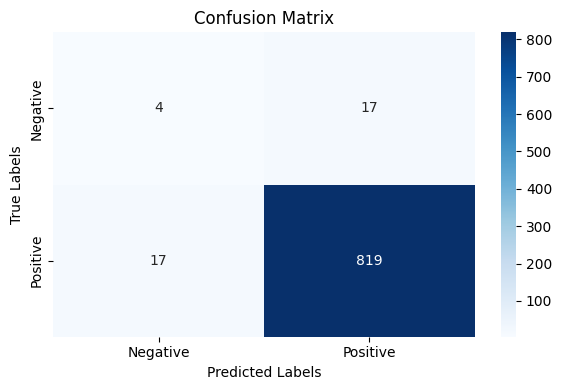

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Given confusion matrix (scaled up for visualization)
confusion_matrix = np.array([
    [4.3888, 17.3888],
    [17.3888, 818.6112]
])

# Scale the matrix values to integers for visualization
confusion_matrix_int = np.round(confusion_matrix).astype(int)

# Plotting the confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(confusion_matrix_int, title='Confusion Matrix')

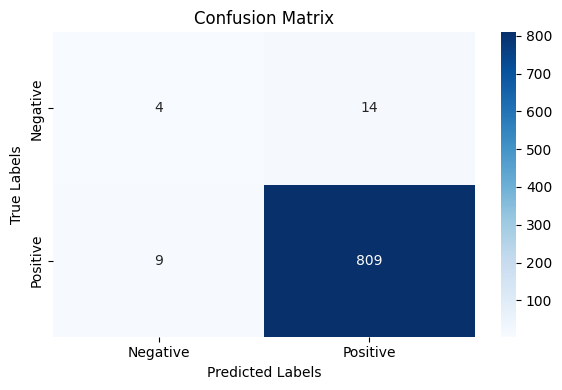

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Confusion matrix values
confusion_matrix = np.array([
[4, 14],
[9, 809]
])
# Plotting the confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(confusion_matrix, title='Confusion Matrix')